In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="your_roboflow_api_key_here")
workspace = rf.workspace()
print(workspace)

loading Roboflow workspace...
{
  "name": "Trafficsignaldetection",
  "url": "trafficsignaldetection-lti5q",
  "projects": [
    "trafficsignaldetection-lti5q/traffic-signal-m5bdo-trspi",
    "trafficsignaldetection-lti5q/traffic_signal_detection"
  ]
}


In [4]:
project = rf.workspace("trafficsignaldetection-lti5q").project("traffic_signal_detection")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to traffic_signal_detection-1 in yolov8:: 100%|██████████| 2564/2564 [00:00<00:00, 3329.88it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Found 999 images in /content/traffic_signal_detection-1/train/images

Inspecting first few images:
  Image: img_803_jpg.rf.f70288ac0e897169e670459655531c7b.jpg, Shape: (512, 512, 3) (Height, Width, Channels)
  Image: 4182bd07c99a3c7e300162a30b38a02a_jpg.rf.2991f6a1fdd979b8593b6a13ea40027c.jpg, Shape: (512, 512, 3) (Height, Width, Channels)
  Image: VID_20230305_140706_000004_jpg.rf.9516c6be172292a9754fe60dcfbd0bd1.jpg, Shape: (512, 512, 3) (Height, Width, Channels)


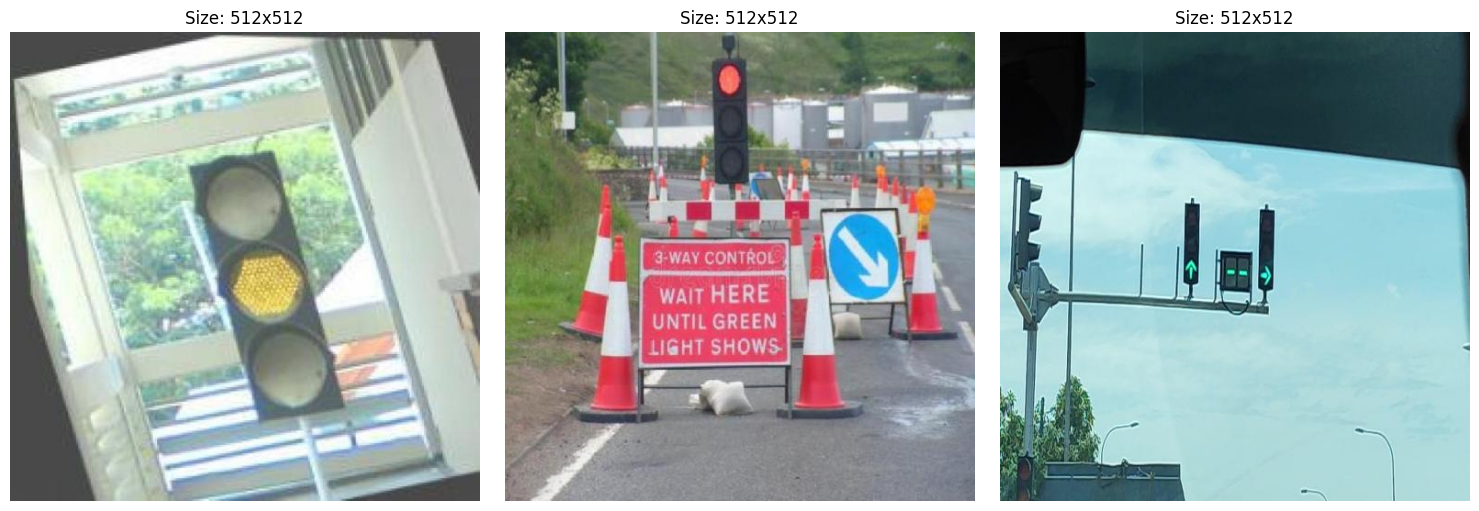

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# Define the path to the dataset images
image_path = os.path.join(dataset.location, 'train', 'images')

# Get a list of image files
image_files = [f for f in os.listdir(image_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Display information for the first few images
num_images_to_display = 3

if not image_files:
    print(f"No image files found in {image_path}")
else:
    print(f"Found {len(image_files)} images in {image_path}")
    print("\nInspecting first few images:")

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_files[:num_images_to_display]):
        img_full_path = os.path.join(image_path, img_name)
        img = cv2.imread(img_full_path)

        if img is not None:
            # OpenCV loads images as BGR, convert to RGB for matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            print(f"  Image: {img_name}, Shape: {img.shape} (Height, Width, Channels)")

            plt.subplot(1, num_images_to_display, i + 1)
            plt.imshow(img_rgb)
            plt.title(f"Size: {img.shape[1]}x{img.shape[0]}")
            plt.axis('off')
        else:
            print(f"  Could not load image: {img_name}")
    plt.tight_layout()
    plt.show()

To visualize the bounding boxes, we need to read the YOLO format `.txt` annotation files associated with each image. These files contain normalized coordinates, so we'll convert them to pixel coordinates to draw on the image. Each line in the `.txt` file typically represents an object with `class_id center_x center_y width height`.

Found 999 images in /content/traffic_signal_detection-1/train/images

Inspecting first few images with bounding boxes:


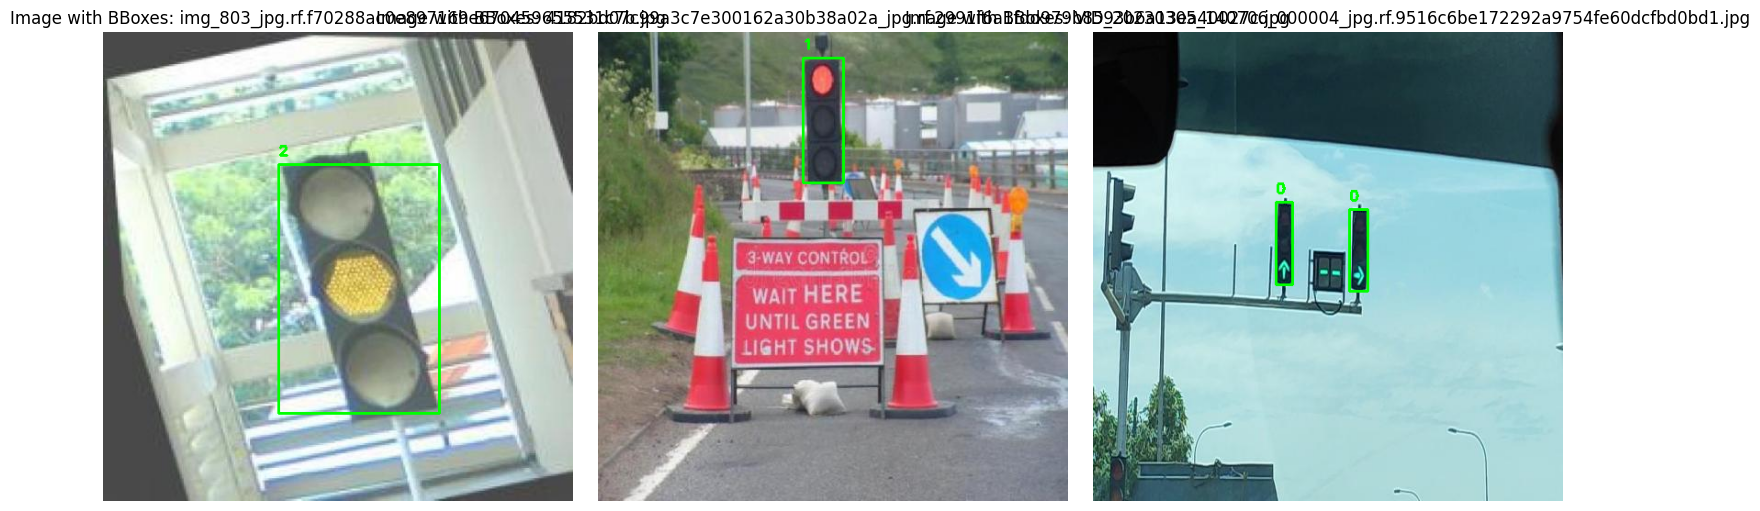

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# Define paths
image_path = os.path.join(dataset.location, 'train', 'images')
label_path = os.path.join(dataset.location, 'train', 'labels')

def plot_boxes(img, labels, class_names):
    h, w, _ = img.shape
    for label in labels:
        # YOLO format: class_id, center_x, center_y, width, height (normalized)
        class_id, x_center, y_center, box_width, box_height = map(float, label.split(' '))

        # Convert normalized coordinates to pixel coordinates
        x_center *= w
        y_center *= h
        box_width *= w
        box_height *= h

        x1 = int(x_center - box_width / 2)
        y1 = int(y_center - box_height / 2)
        x2 = int(x_center + box_width / 2)
        y2 = int(y_center + box_height / 2)

        # Draw rectangle (bounding box)
        color = (0, 255, 0) # Green color
        thickness = 2
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

        # Put class name (optional, if you have class names)
        class_name = class_names[int(class_id)] if class_names else str(int(class_id))
        cv2.putText(img, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)
    return img

# Load class names from data.yaml (assuming it's available)
import yaml
with open(os.path.join(dataset.location, 'data.yaml'), 'r') as f:
    data_yaml = yaml.safe_load(f)
    class_names = data_yaml['names']

# Get a list of image files
image_files = [f for f in os.listdir(image_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

num_images_to_display = 3

if not image_files:
    print(f"No image files found in {image_path}")
else:
    print(f"Found {len(image_files)} images in {image_path}")
    print("\nInspecting first few images with bounding boxes:")

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(image_files[:num_images_to_display]):
        img_full_path = os.path.join(image_path, img_name)
        label_name = img_name.replace(os.path.splitext(img_name)[1], '.txt')
        label_full_path = os.path.join(label_path, label_name)

        img = cv2.imread(img_full_path)

        if img is not None:
            # Read labels
            labels = []
            if os.path.exists(label_full_path):
                with open(label_full_path, 'r') as f:
                    labels = f.readlines()
            else:
                print(f"  No label file found for {img_name}")

            # Draw bounding boxes
            img_with_boxes = plot_boxes(img.copy(), labels, class_names)

            # OpenCV loads images as BGR, convert to RGB for matplotlib
            img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

            plt.subplot(1, num_images_to_display, i + 1)
            plt.imshow(img_rgb)
            plt.title(f"Image with BBoxes: {img_name}")
            plt.axis('off')
        else:
            print(f"  Could not load image: {img_name}")
    plt.tight_layout()
    plt.show()

In [7]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')  # Nano for speed; use yolov8s.pt for better accuracy
results = model.train(data='traffic_signal_detection-1/data.yaml', epochs=10, imgsz=512)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=traffic_signal_detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

Now that the model is trained, let's evaluate its performance on the validation set using `model.val()`.

You can now test the trained model on a custom image. Provide the path to your image, and the model will perform object detection and display the results.


image 1/1 /content/traffic_signal_detection-1/test/images/traffic-light-990-_jpg.rf.322a30fb2c62af55c1d3e95c5333987b.jpg: 512x512 1 1, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)


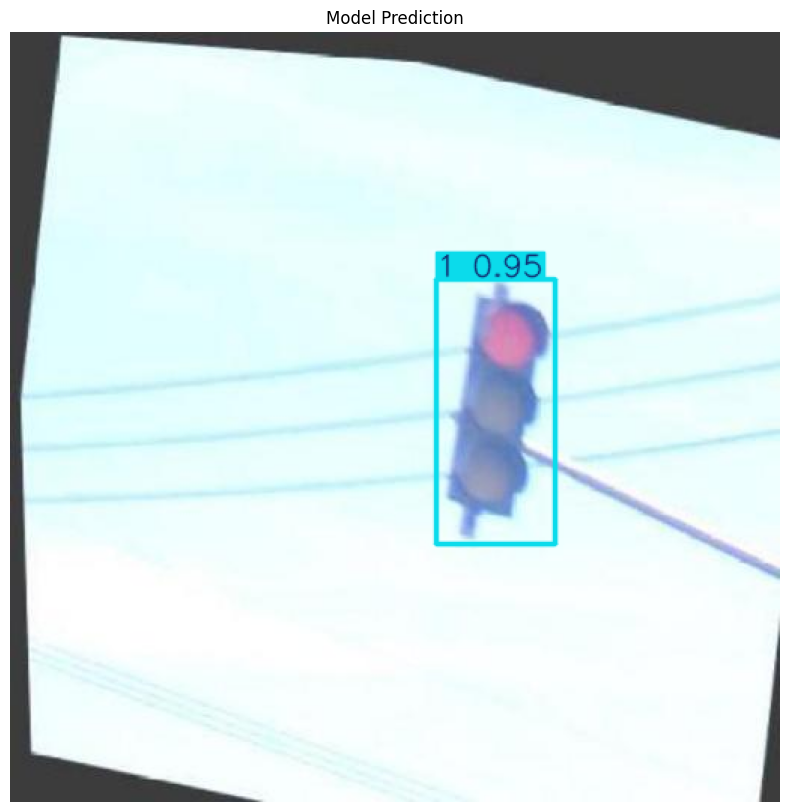

In [10]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# Ensure the model is loaded (it should be from previous steps, but good practice to ensure)
# model = YOLO('yolov8n.pt') # Uncomment and run if model is not already loaded in the environment

# Hardcoded path to the image for prediction
image_to_predict_path = "/content/traffic_signal_detection-1/test/images/traffic-light-990-_jpg.rf.322a30fb2c62af55c1d3e95c5333987b.jpg"

# Check if the file exists
if not os.path.exists(image_to_predict_path):
    print(f"Error: Image not found at {image_to_predict_path}")
else:
    # Perform prediction
    results = model.predict(source=image_to_predict_path, conf=0.25)  # conf is confidence threshold

    # Iterate through results and display
    for r in results:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im_rgb = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB) # convert to RGB

        plt.figure(figsize=(10, 10))
        plt.imshow(im_rgb)
        plt.title("Model Prediction")
        plt.axis('off')
        plt.show()


### 1. Access Specific Metrics

Let's retrieve and display specific global and per-class metrics from the `metrics` object.

In [21]:
print("--- Overall Metrics ---")
print(f"mAP50: {metrics.box.map50}") # Mean Average Precision at IoU=0.50
print(f"mAP50-95: {metrics.box.map}") # Mean Average Precision over IoU=0.50:0.95
print(f"Overall Precision: {metrics.box.mp}") # Mean Precision
print(f"Overall Recall: {metrics.box.mr}") # Mean Recall

print("\n--- Per-Class Metrics ---")
# 'names' attribute from data.yaml stores class names
for i, class_name in enumerate(data_yaml['names']):
    print(f"Class {class_name}:")
    # metrics.box.p[i] is precision for class i
    # metrics.box.r[i] is recall for class i
    # metrics.box.ap50[i] is AP50 for class i
    # metrics.box.ap[i] is AP50-95 for class i
    print(f"  Precision: {metrics.box.p[i]:.4f}")
    print(f"  Recall: {metrics.box.r[i]:.4f}")
    print(f"  AP50: {metrics.box.ap50[i]:.4f}")
    print(f"  AP50-95: {metrics.box.ap[i]:.4f}")

--- Overall Metrics ---
mAP50: 0.8588613738073567
mAP50-95: 0.518674744855878
Overall Precision: 0.9416911641010605
Overall Recall: 0.7525764895330113

--- Per-Class Metrics ---
Class 0:
  Precision: 0.9868
  Recall: 0.6522
  AP50: 0.8195
  AP50-95: 0.5240
Class 1:
  Precision: 0.9084
  Recall: 0.8000
  AP50: 0.8917
  AP50-95: 0.5068
Class 2:
  Precision: 0.9299
  Recall: 0.8056
  AP50: 0.8654
  AP50-95: 0.5253


### 2. Visualize the Confusion Matrix

The confusion matrix helps visualize the performance of an algorithm, typically in supervised learning, but adapted for object detection to show how often objects are correctly detected and classified versus being misclassified or missed.

In [32]:
import matplotlib.pyplot as plt

# Plot the confusion matrix (normalized)
# The plot() method saves the figure to runs/detect/val/confusion_matrix.png by default.
# It also returns the matplotlib figure object if you want to display it directly.
confusion_matrix_fig = metrics.confusion_matrix.plot(normalize=True)
plt.show()

### 3. Plot Precision-Recall (PR) Curves

Precision-Recall curves are essential for object detection to understand the trade-off between precision and recall across different detection thresholds.

Checking contents of /content/runs/detect/val:
['val_batch2_labels.jpg', 'BoxF1_curve.png', 'val_batch0_pred.jpg', 'val_batch1_pred.jpg', 'BoxPR_curve.png', 'confusion_matrix.png', 'val_batch0_labels.jpg', 'val_batch1_labels.jpg', 'BoxR_curve.png', 'BoxP_curve.png', 'val_batch2_pred.jpg', 'confusion_matrix_normalized.png']
Looking for BoxP_curve.png in /content/runs/detect/val
Displaying Precision-Recall curve:


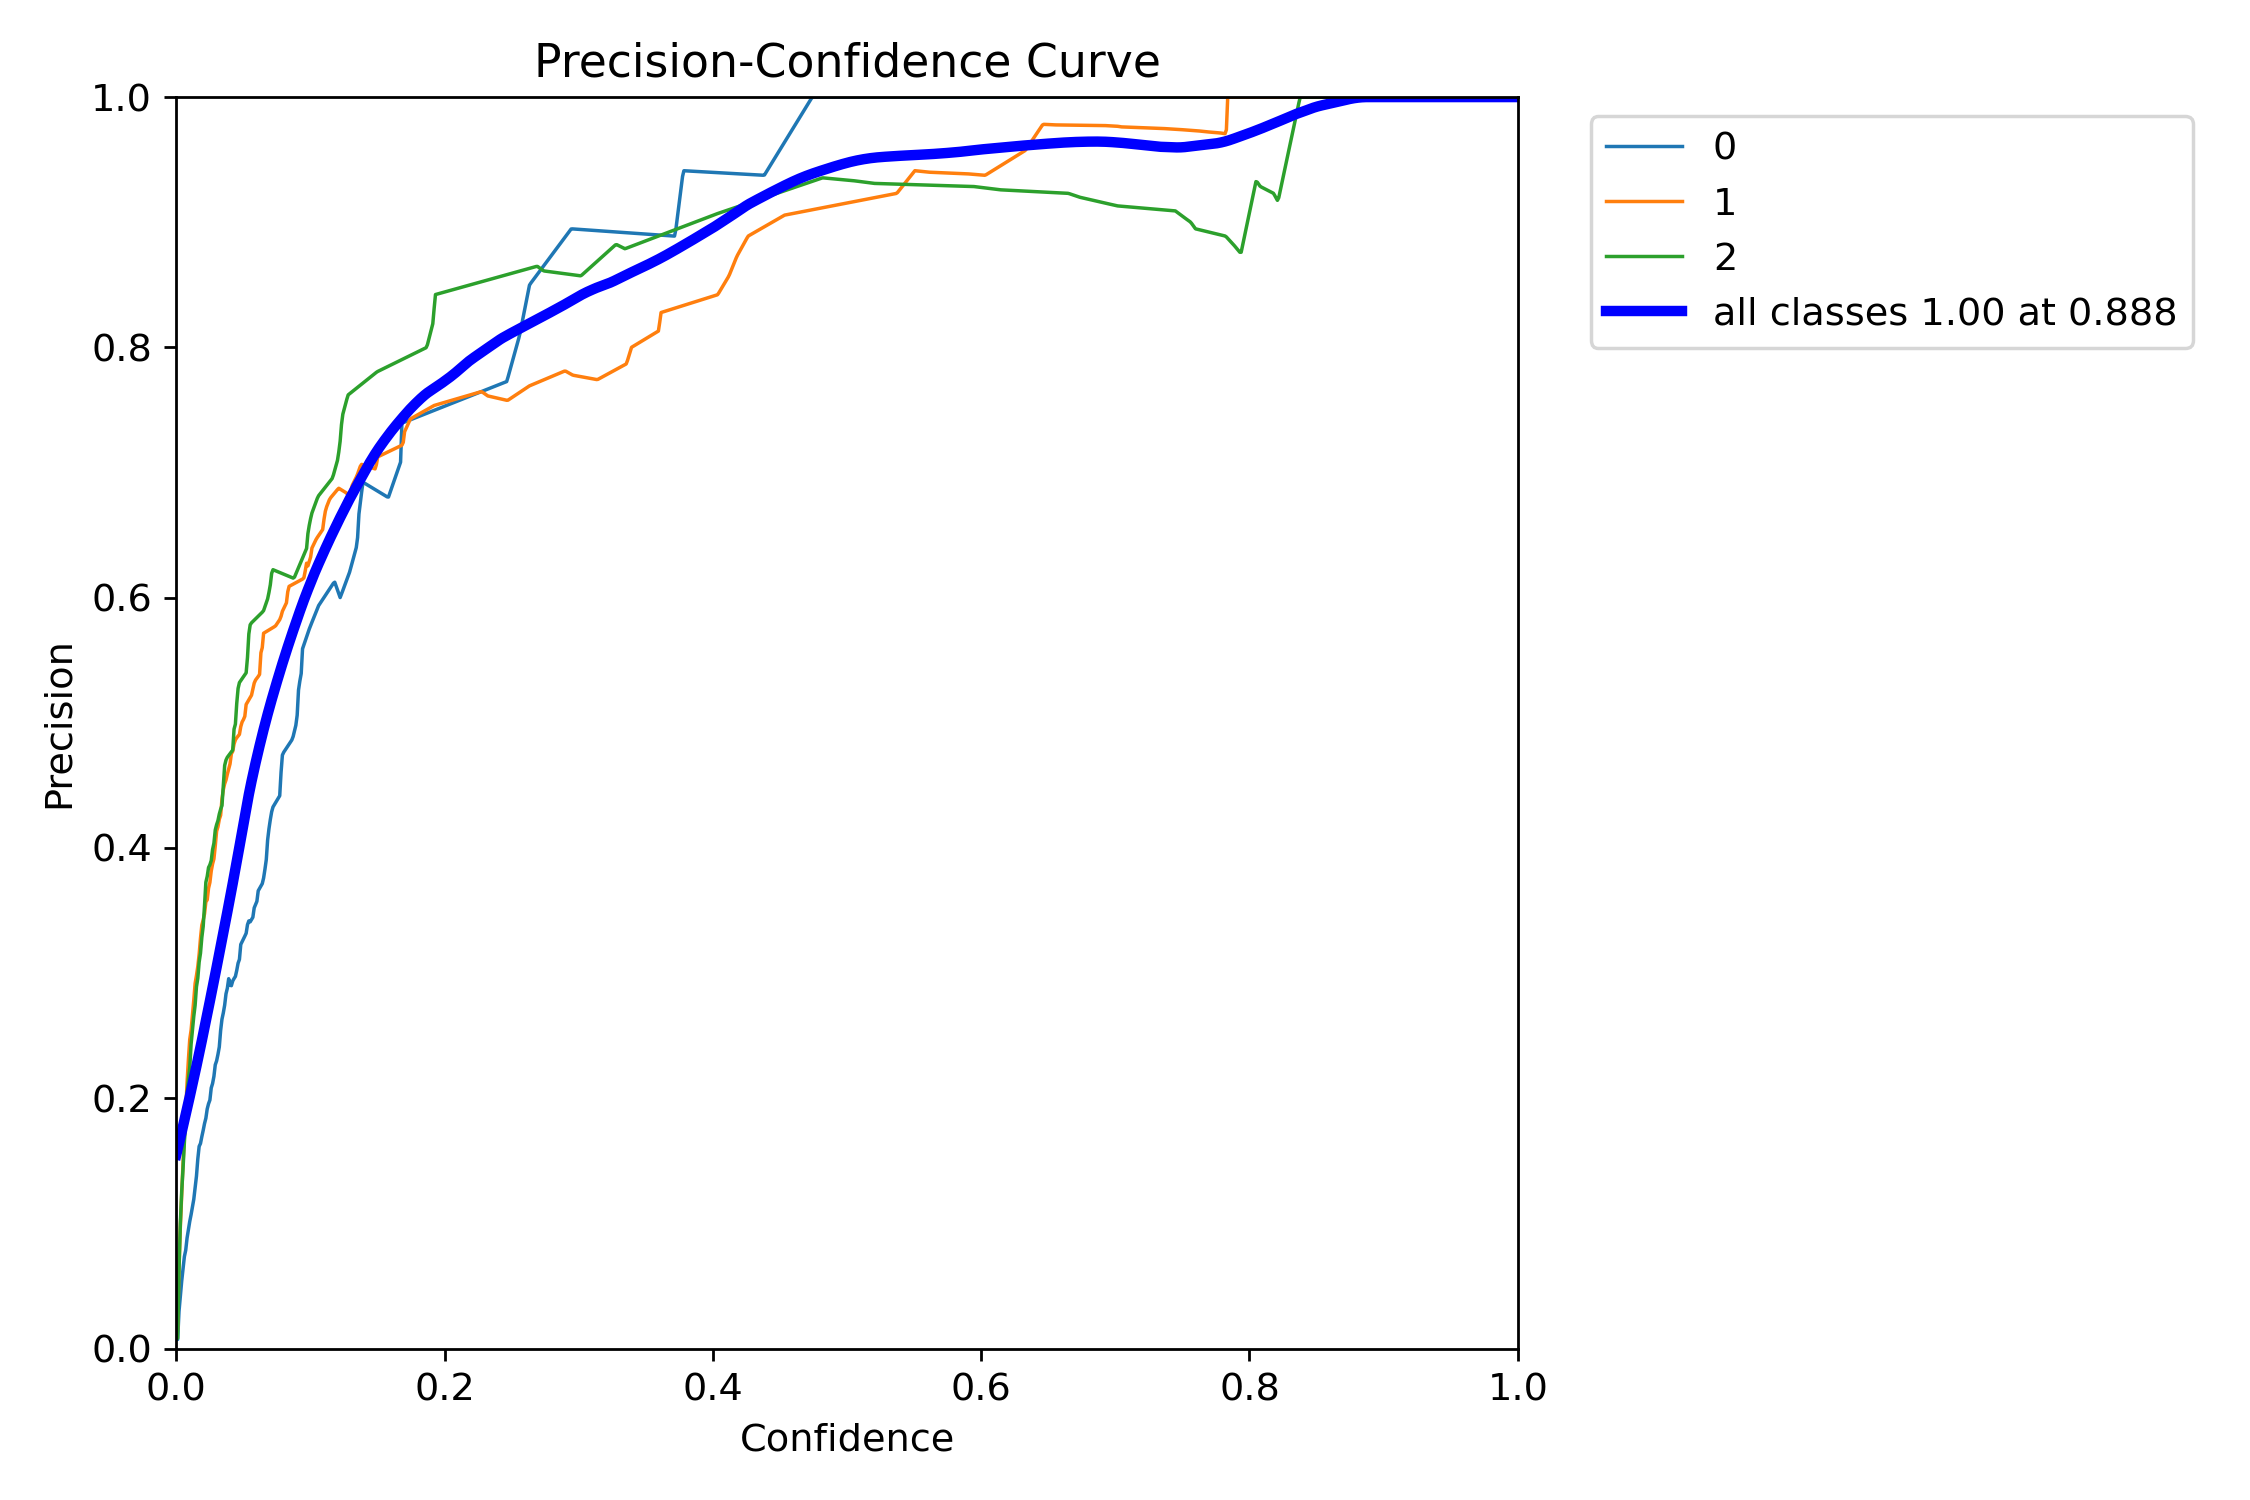

In [29]:
# Plot all Precision-Recall curves (one for each class and an overall)
# The plot() method saves the figure to runs/detect/val/P_curve.png by default
# metrics.plot(plot_curves=True) also generates these, but we can access them directly.

# The metrics object stores these plots, you can replot them or inspect the arrays
# For simplicity, let's just show how to access the saved plots or recreate a plot.

# Ultralytics saves these plots to the results directory. We can load and display them.
import glob
from IPython.display import Image, display
import os

val_run_dir = metrics.save_dir

# The plots are generated automatically by model.val() and saved to metrics.save_dir
# Do NOT call metrics.plot() as it's not a valid method on DetMetrics object.

print(f"Checking contents of {val_run_dir}:")
if os.path.exists(val_run_dir):
    print(os.listdir(val_run_dir))
else:
    print(f"Directory {val_run_dir} does not exist.")

print(f"Looking for BoxP_curve.png in {val_run_dir}")
pr_curve_path = os.path.join(val_run_dir, 'BoxP_curve.png') # Corrected filename

if os.path.exists(pr_curve_path):
    print("Displaying Precision-Recall curve:")
    display(Image(filename=pr_curve_path))
else:
    print(f"Precision-Recall curve image not found at {pr_curve_path}. "
          "This should have been generated by model.val(). Please check the directory manually if needed.")

### 4. Plot F1-Confidence Curve

This curve shows the F1-score (harmonic mean of precision and recall) at various confidence thresholds, helping you pick an optimal threshold for your application.

Displaying F1-Confidence curve:


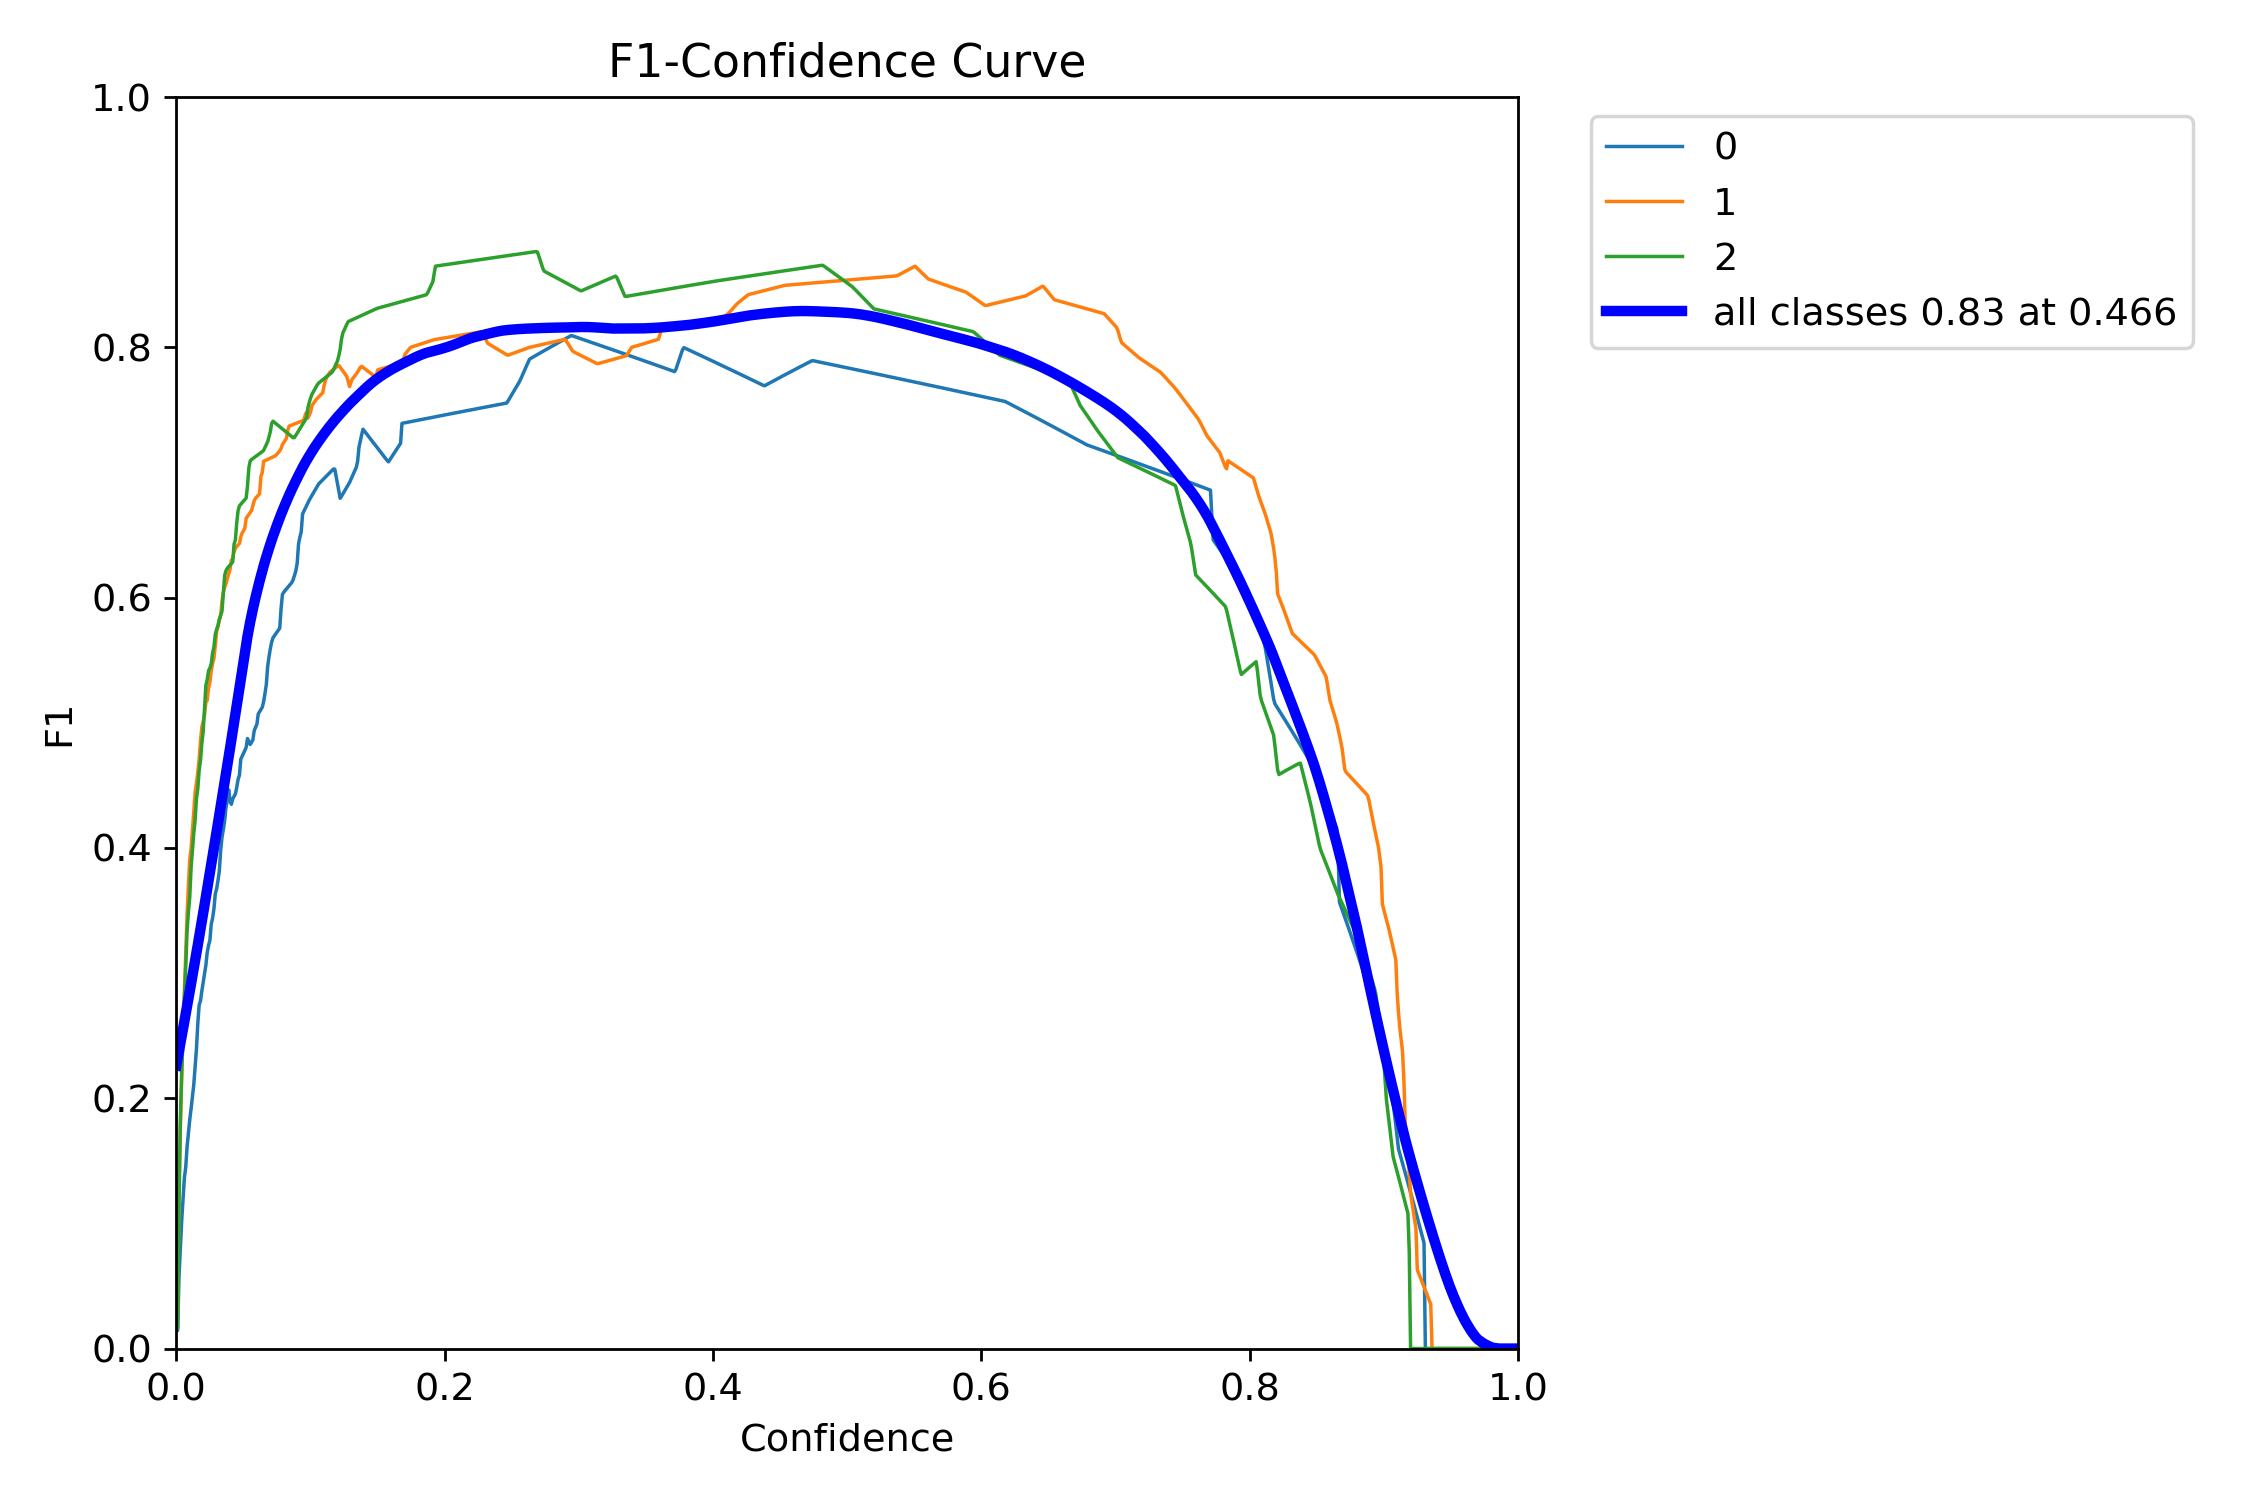

In [30]:
import os
from IPython.display import Image, display

val_run_dir = metrics.save_dir # Ensure val_run_dir is correctly set

f1_curve_path = os.path.join(val_run_dir, 'BoxF1_curve.png') # Corrected filename

if os.path.exists(f1_curve_path):
    print("Displaying F1-Confidence curve:")
    display(Image(filename=f1_curve_path))
else:
    print(f"F1-Confidence curve image not found at {f1_curve_path}. "
          "This should have been generated by model.val(). Please check the directory manually if needed.")

In [8]:
metrics = model.val(data='traffic_signal_detection-1/data.yaml')
print(metrics)

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1416.8±442.6 MB/s, size: 39.6 KB)
val: Scanning /content/traffic_signal_detection-1/valid/labels.cache... 101 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 101/101 30.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.7it/s 1.9s
                   all        101        119      0.942      0.753      0.859      0.519
                     0         19         23      0.987      0.652       0.82      0.524
                     1         48         60      0.908        0.8      0.892      0.507
                     2         35         36       0.93      0.806      0.865      0.525
Speed: 3.5ms preprocess, 4.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /content/runs/detect/va